In [1]:
import streamlit_functions as sf
import importlib as imp
import geopandas as gpd
import matplotlib.pyplot as plt
import functions as f
import requests
# debugging
import importlib as imp
imp.reload(f)

# graph
import networkx as nx
import h3
from functions import H3_INDEX_RESOLUTION
from shapely.geometry import Point, LineString
import geopandas as gpd

import polyline

### shortest path API - openrouteservice

only one problem is there is only one shortest path

In [3]:
import openrouteservice

# Replace 'your_api_key_here' with your actual OpenRouteService API key
client = openrouteservice.Client(key="5b3ce3597851110001cf62488e1d38b412854808ac6fe5f922a3c5bb")

# Define your coordinates
coordinates = [[11.581726, 55.606109], [11.699829, 55.592143]]  # Sjeland
coordinates4 = [[10.217285, 57.421294], [10.568847, 55.235288]] # super funky long, it will fail (no path)
coordinates5 = [[10.217285, 57.421294], [9.074707, 54.933455]]
coordinates6 = [[10.217285, 57.421294], [10.568847, 55.235288], [9.074707, 54.933455]]

coordinates = coordinates6

# Make a request to the OpenRouteService API for cycling routes
routes = client.directions(coordinates=coordinates,
                           profile='cycling-regular',
                           format='geojson')

# The response 'routes' will be a GeoJSON object containing the route
gdf_routes = gpd.GeoDataFrame.from_features(routes['features'])
gdf_routes.crs = 'EPSG:4326'
gdf_routes.explore()

### Shortest Path - GrapHooper

In [4]:
import requests

# Your GraphHopper API key
api_key = '50f71572-e60f-4618-8abf-ab02d87b1522'

coordinates3 = [[12.200317, 55.864524], [11.881714, 55.523967]] # big distance
coordinates4 = [[10.217285, 57.421294], [10.568847, 55.235288]] # super funky long, it will fail (no path)
coordinates5 = [[10.217285, 57.421294], [9.074707, 54.933455]]


coordinates = coordinates5

# Define start and end points

start_point = f'{coordinates[0][1]}, {coordinates[0][0]}'
end_point = f'{coordinates[1][1]}, {coordinates[1][0]}'

# Construct the request URL
url = f'https://graphhopper.com/api/1/route?point={start_point}&point={end_point}&vehicle=bike&locale=en&key={api_key}'

# Make the request
response = requests.get(url)
data = response.json()

data['paths'][0]["points"]
decoded_polyline = polyline.decode(data['paths'][0]["points"])
decoded_polyline = [(lon, lat) for lat, lon in decoded_polyline]

# Convert the list of coordinates to a LineString geometry
geometry = LineString(decoded_polyline)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[geometry])

gdf.explore()

### find closest bikelines based on the h3 index - our implementations

Loading the graph takes a minute

In [5]:
# load Graph
import gzip
# Open the gzipped file and load the graph
with gzip.open('graphProjected.graphml.gz', 'rb') as gz_file:
    G = nx.read_graphml(gz_file)

In [55]:
# below code also takes time. This graph loading is crazy

In [6]:
# Convert node labels to integers
mapping = {node: int(node) for node in G.nodes()}
G = nx.relabel_nodes(G, mapping)

In [7]:
bikelane_all = gpd.read_parquet('dataset/raw_unprocessed/bikelane_dk_WGS84_h3_indexed.parquet')

In [8]:
coordinates1 = [[11.581726, 55.606109], [11.699829, 55.592143]] # sjeland
coordinates2 = [[12.473907, 55.717571], [12.561798, 55.695132]] # in Copenhagen
coordinates3 = [[12.200317, 55.864524], [11.881714, 55.523967]] # big distance
coordinates4 = [[10.217285, 57.421294], [10.568847, 55.235288]] # super funky long, it will fail (no path)
coordinates5 = [[10.217285, 57.421294], [9.074707, 54.933455]]

# Create LineString objects from the coordinates
line1 = LineString(coordinates1)
line2 = LineString(coordinates2)
line3 = LineString(coordinates3)
line4 = LineString(coordinates4)
line5 = LineString(coordinates5)

# Create a GeoDataFrame from the LineStrings
data = {'geometry': [line1, line2, line3, line4, line5], "Line Number": [1, 2, 3, 4, 5]}
gdf = gpd.GeoDataFrame(data)
gdf.crs = 'EPSG:4326'

gdf.explore()

In [10]:
# Assuming 'bikelane_all' is your GeoDataFrame of bike lanes
# and 'coordinates2' are your start and end points in Copenhagen

# Convert points to Shapely Points

COORDS = coordinates3

start_point = Point(COORDS[0])
end_point = Point(COORDS[1])


# Function to find the closest LineString to a point, considering H3 index
def find_closest_objects(point, gdf):
    point_h3_index = f.get_h3_index_from_point(point)
    # Filter linestrings by H3 index
    filtered_gdf = gdf[gdf['h3_index'] == point_h3_index]
    if len(filtered_gdf) == 0:
        # If no lines are found in the same H3 index, search in the neighboring indexes
        neighbors = h3.k_ring(point_h3_index, 1)
        filtered_gdf = gdf[gdf['h3_index'].isin(neighbors)]
    
    min_dist = float('inf')
    closest_line = None
    for row in filtered_gdf.itertuples():
        # Calculate the distance from the point to the current line
        dist = point.distance(row.geometry)
        if dist < min_dist:
            min_dist = dist
            closest_line = row.geometry
            closest_edge = row.Index  # itertuples gives us the index in the 'Index' attribute
            closest_line_point = f.closest_coordinate_on_linestring(point, closest_line)
    return closest_line, closest_edge[0:2], closest_line_point, filtered_gdf

# Find closest LineStrings to start and end points

closest_line_start, closest_edge_start, start_closest_line_endpoints, filtered_gdf_1 = find_closest_objects(start_point, bikelane_all)
closest_line_end, closest_edge_end, end_closest_line_endpoints, filtered_gdf_2 = find_closest_objects(end_point, bikelane_all)
print(closest_edge_start, start_closest_line_endpoints)
print(closest_edge_end, end_closest_line_endpoints)


(1756628177, 10138199326) POINT (12.2003564 55.8647522)
(1326937882, 5611255165) POINT (11.882419 55.523005)


### Preparing for shortest path -  run it only once

Making a network, takes time. If you already read it, skip this step

In [11]:
bikelane_all_projected = bikelane_all.to_crs(f.DENMARK_CRS)

In [64]:
# Initialize an empty list to store edges
edge_list = []

# Loop through the DataFrame using itertuples
for row, projected_row in zip(bikelane_all.itertuples(index=True, name='Edge'), bikelane_all_projected.itertuples(index=True, name='Edge')):
    # Extract source, target, and other relevant columns from the row tuple
    # print(row[1])
    source = row[0][0]  # Extract u from the multi-index
    target = row[0][1]  # Extract v from the multi-index
    geometry_denmark = row[1]
    length = geometry_denmark.length
    
    # Append the edge to the edge list
    # edge_list.append((source, target, {'geometry': geometry, 'length': length}))
    edge_list.append((int(source), int(target), {'length_in_meter': length}))

# Display the edge list
# print(edge_list)
G = nx.from_edgelist(edge_list, create_using=nx.DiGraph())

### Shortest path


######### WTF is simple_path? 

In [12]:
from itertools import islice
simple_paths = []
def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, closest_edge_start[0], closest_edge_end[1], weight=weight), k)
    )
for path in k_shortest_paths(G, 0, 3, k=40):
    simple_paths.append(path)

In [86]:
# path = nx.shortest_path(G, source=closest_edge_start[0], target=closest_edge_end[1], weight='length_in_meter')
results_gpd = gpd.GeoDataFrame()
for p in simple_paths:
    l = []
    for vertex in range(len(p)-1):
        u = p[vertex]
        v = p[vertex + 1]
        l.append((u, v, 0))

    result = bikelane_all.loc[l]
    result = result.unary_union
    result = gpd.GeoDataFrame(geometry=[result])
    results_gpd = results_gpd.append(result)
results_gpd.explore()

,geometry
0,"MULTILINESTRING ((12.47774 55.71711, 12.47817 ..."


AttributeError: 'GeoDataFrame' object has no attribute 'append'

In [91]:
# Assuming bikelane_all is your GeoDataFrame containing all bikelanes
# and simple_paths is a list of paths where each path is a list of nodes

geo_series_list = []

for p in simple_paths:
    l = []
    for vertex in range(len(p)-1):
        u = p[vertex]
        v = p[vertex + 1]
        l.append((u, v, 0))
    
    # Accessing the segments from bikelane_all
    result = bikelane_all.loc[l]
    
    # Combining the geometries into a single geometry
    combined_geometry = result.geometry.unary_union
    
    # Append the combined geometry to the list
    geo_series_list.append(combined_geometry)

# Creating a GeoDataFrame from the list of combined geometries
results_gpd = gpd.GeoDataFrame(geometry=geo_series_list)
results_gpd.crs = 'EPSG:4326'

# Now you can use results_gpd for further processing or visualization
results_gpd.explore()  # Assuming you have the .explore() method set up properly

In [81]:
l = []
for vertex in range(len(simple_paths[0])-1):
    u = simple_paths[0][vertex]
    v = simple_paths[0][vertex + 1]
    l.append((u, v, 0))

result = bikelane_all.loc[l]

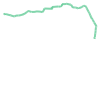

In [84]:
result.unary_union

### The graphs somehow must be loaded and saved

In [67]:
import gzip
nx.write_graphml(G, gzip.open('graphProjected.graphml.gz', 'wb'))

In [205]:
nx.write_gml(G, "test.gml")

In [200]:
import tempfile
with tempfile.NamedTemporaryFile(delete=False) as f:
    nx.write_graph6(G, f.name)
    _ = f.seek(0)
    print(f.read())

NetworkXNotImplemented: not implemented for directed type

In [185]:
# Load the graph
import gzip
import networkx as nx

# Decompress the GraphML file
with gzip.open('graphWGS84.graphml.gz', 'rb') as f:
    # Read the graph from the decompressed file
    G = nx.read_graphml(f)

In [197]:
# Convert node labels to integers
mapping = {node: int(node) for node in G.nodes()}
G = nx.relabel_nodes(G, mapping)

In [191]:
# get some nodes 
nodes = list(G.nodes)

In [195]:
'676544' in nodes

True

### Shortest Path

#### THIS IS IT

 #### Faster index